In [13]:
import pandas as pd
import numpy as np
import urllib, json
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
# from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PolyCollection
import seaborn as sns
import datetime as dt
import geopandas as gpd
from geopandas import GeoDataFrame
import folium
from shapely.geometry import Point, Polygon
from keplergl import KeplerGl
import data_describe as dd

# set the standard plot size
plt.rcParams['figure.figsize']=(30,15)

In [3]:
# get the "Confirmed positive cases of COVID19 in Ontario" data
# https://data.ontario.ca/en/dataset/confirmed-positive-cases-of-covid-19-in-ontario
# import data using the ontario open data API
# make sure to check the limit against current cases
url = "https://data.ontario.ca/en/api/3/action/datastore_search?resource_id=455fd63b-603d-4608-8216-7d8647f43350&limit=500000"
response = urllib.request.urlopen(url)
data = json.loads(response.read().decode('utf-8'))

# use this if you want to see the json
# print (data['result']['records'])

# use this if you want to write it to a pandas dataframe
conpos_df = pd.DataFrame(data['result']['records'])

In [4]:
# get the "Status of COVID-19 Cases in Ontario" data
# https://data.ontario.ca/dataset/status-of-covid-19-cases-in-ontario
# make sure to check the limit against current cases
url = "https://data.ontario.ca/en/api/3/action/datastore_search?resource_id=ed270bb8-340b-41f9-a7c6-e8ef587e6d11&limit=500000"
response = urllib.request.urlopen(url)
data = json.loads(response.read().decode('utf-8'))

# use this if you want to see the json
# print (data['result']['records'])

status_df = pd.DataFrame(data['result']['records'])

In [14]:
# share this tool - https://github.com/data-describe/data-describe
dd.data_summary(status_df)

/home/gbby/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning:

invalid value encountered in reduce



,Info
Rows,370
Columns,20
Size in Memory,60.7 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
_id,int64,0,0,1,185.50,370,185.50,106.81,370,1
Reported Date,object,0,0,,,,,,370,1
Confirmed Negative,float64,323,0,,,,,,47,323
Presumptive Negative,float64,358,0,,,,,,8,358
Presumptive Positive,float64,345,0,,,,,,3,345
Confirmed Positive,float64,2,0,0,3791.50,30632,,,346,9
Resolved,float64,12,0,1,37170.50,259991,,,324,12
Deaths,float64,40,0,1,,6555,,,301,40
Total Cases,float64,2,0,1,40103.50,280494,,,350,15
Total patients approved for testing as of Reporting Date,float64,6,0,139,2483453,10085123,,,364,6


None

data-describe Summary Widget

data-describe Scatter Plot Widget

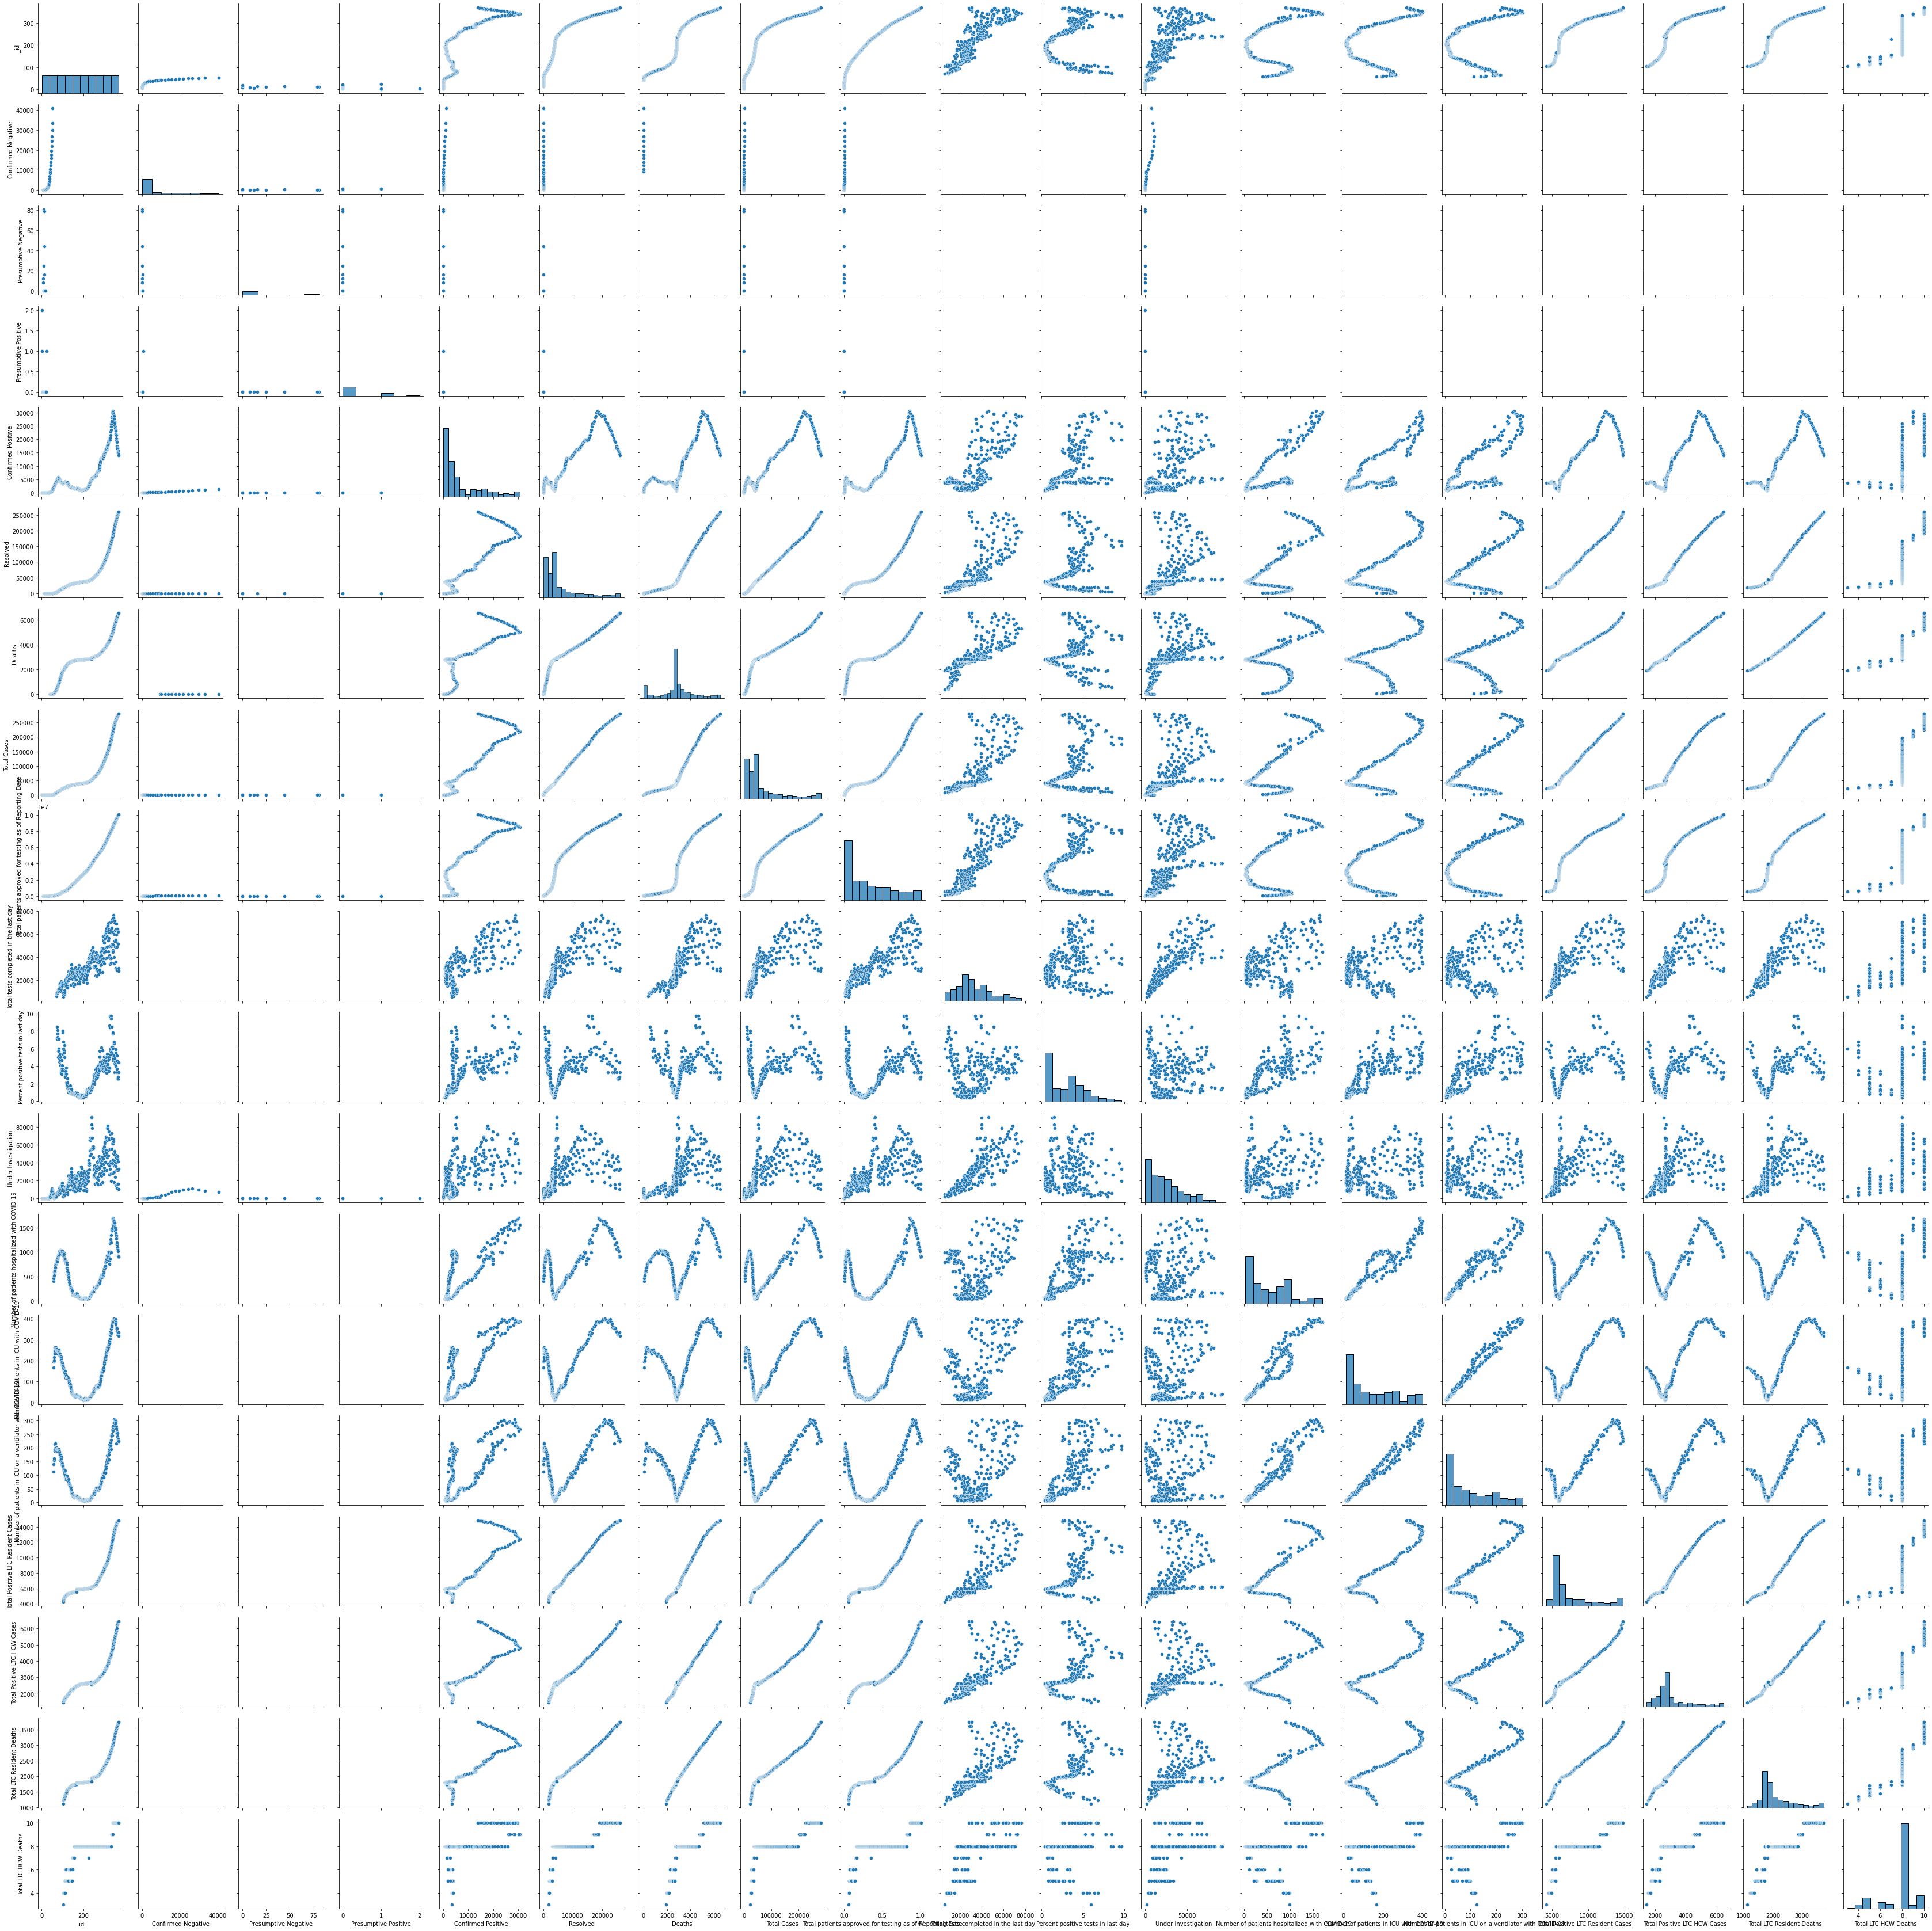

In [15]:
dd.scatter_plots(status_df, plot_mode='matrix')

<AxesSubplot:title={'center':'Correlation Matrix'}>

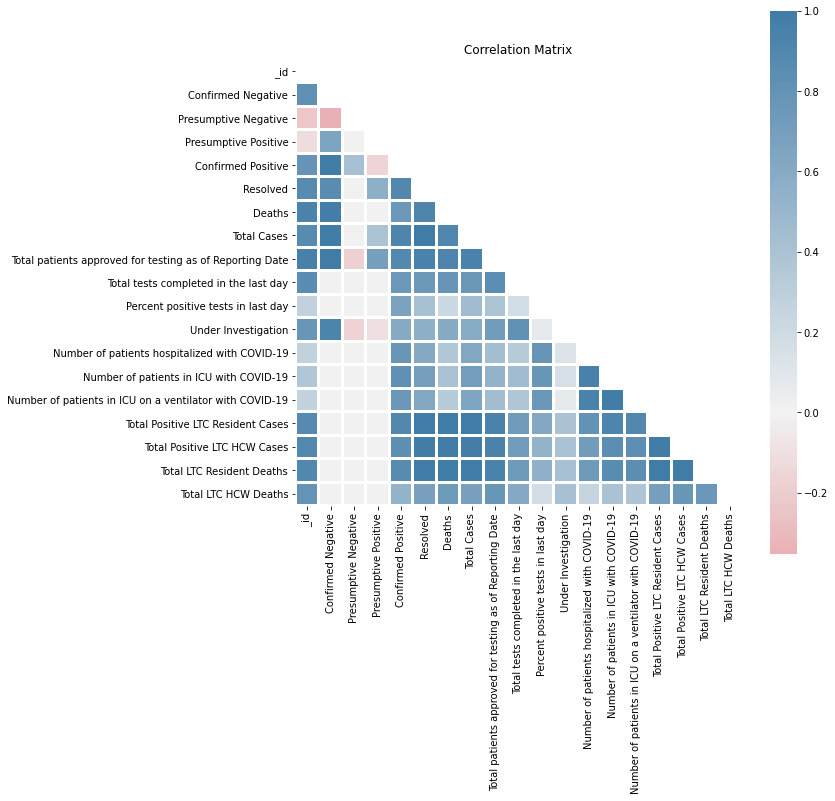

In [16]:
dd.correlation_matrix(status_df)

In [5]:
# sort by date
conpos_df = conpos_df.sort_values(by=['Accurate_Episode_Date'], ascending=False);
status_df = status_df.sort_values(by=['Reported Date'], ascending=True);

In [6]:
# set the dates to datetime64 for later use
conpos_df["Accurate_Episode_Date"] = conpos_df["Accurate_Episode_Date"].astype("datetime64")
conpos_df["Case_Reported_Date"] = conpos_df["Case_Reported_Date"].astype("datetime64")
conpos_df["Test_Reported_Date"] = conpos_df["Test_Reported_Date"].astype("datetime64")
conpos_df["Specimen_Date"] = conpos_df["Specimen_Date"].astype("datetime64")

## Some Geodata Resources

- U of T map and data library resources https://mdl.library.utoronto.ca/collections/numeric-data/census-canada/2016/geo
- where to get geojson files https://stackoverflow.com/questions/17267248/how-where-do-i-get-geojson-data-for-states-provinces-and-administrative-region
- creating geojson from canada census divisions
https://blog.exploratory.io/making-maps-for-canadas-provisions-and-census-divisions-in-r-c189b88ccd8a
- creating geojson for toronto area codes https://medium.com/dataexplorations/generating-geojson-file-for-toronto-fsas-9b478a059f04
- ontario public health units https://geohub.lio.gov.on.ca/datasets/ministry-of-health-public-health-unit-boundary
- more ontario geodatasets https://geohub.lio.gov.on.ca/datasets/11be9127e6ae43c4850793a3a2ee943c_13
- potentially a fun shapefile to play with https://data.ontario.ca/dataset/provincially-licensed-meat-plants
- ttc shapefile https://open.toronto.ca/dataset/ttc-subway-shapefiles/

In [7]:
# let's slice up our original DF to get counts from each public health unit
conpos_df1 = conpos_df[['_id','Reporting_PHU','Outcome1']]

In [8]:
# need to fix all these so they write column names properly
resolved = conpos_df1[conpos_df1.Outcome1 == 'Resolved'].groupby(['Reporting_PHU']).agg(['count']).drop(['Outcome1'], axis=1)
#resolved.to_csv('data/ontario_covid_resolved_by_phu.csv')
#resolved.head()
not_resolved = conpos_df1[conpos_df1.Outcome1 == 'Not Resolved'].groupby(['Reporting_PHU']).agg(['count']).drop(['Outcome1'], axis=1)
#not_resolved.to_csv('data/ontario_covid_active_by_phu.csv')
#not_resolved.head()
fatal = conpos_df1[conpos_df1.Outcome1 == 'Fatal'].groupby(['Reporting_PHU']).agg(['count']).drop(['Outcome1'], axis=1)
#fatal.to_csv('data/ontario_covid_deaths_by_phu.csv')
#fatal.head()

In [9]:
fatal.head()

,_id
,count
Reporting_PHU,
Algoma Public Health Unit,2
Brant County Health Unit,14
Chatham-Kent Health Unit,9
Durham Region Health Department,287
Eastern Ontario Health Unit,70


In [11]:
map_ontario = folium.Map(location=[43.653963, -79.387207], zoom_start=10)
ontario_geo = "./geodata/ontario_phu.geojson"
folium.Choropleth(
    geo_data=ontario_geo,
    data = fatal,
    columns=['Reporting_PHU','count_id'],
    key_on='feature.properties.PHU_NAME_E',
    fill_color='YlOrRd',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Active Cases by Reporting PHU').add_to(map_ontario)   
    
map_ontario

KeyError: "None of ['Reporting_PHU'] are in the columns"